In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import preprocessor
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
import warnings
import random
import os
import preprocessor

In [3]:
data_folder_name = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 6/temp'

if not os.path.exists('C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 6/temp'):
    os.makedirs('C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 6/temp')

In [4]:
batch_size = 500
embedding_size = 200
vocabulary_size = 15000
iterations= 5000
learning_rate = 0.001
num_sampled = int(batch_size/2)    
window_size = 4 

save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

In [5]:
stops = stopwords.words('english')

In [6]:
valid_words = ['love', 'romance', 'sad', 'average', 'boring', 'entertaining', 'exciting', 'excellent', 'fantastic', 'action', 'thriller', 'horror', 'adventure', 'suspenseful']

In [7]:
print('Loading Data ... ')
texts, target = preprocessor.load_movie_data()

Loading Data ... 


In [8]:
print('Normalizing Text Data ... ')
texts = preprocessor.normalize_text(texts, stops)

Normalizing Text Data ... 


In [9]:
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 3]
texts = [x for x in texts if len(x.split()) > 3]  

In [10]:
print('Creating Dictionary ... ')
word_dictionary = preprocessor.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = preprocessor.text_to_numbers(texts, word_dictionary)

Creating Dictionary ... 


In [11]:
text_data = [x for x in text_data if len(x)>=(2*window_size+1)]

In [12]:
valid_examples = [word_dictionary[x] for x in valid_words] 

In [13]:
print('Creating Model ... ')
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

Creating Model ... 


In [14]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [15]:
x_inputs = tf.placeholder(tf.int32, shape=[batch_size, 2*window_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [16]:
embed = tf.zeros([batch_size, embedding_size])
for element in range(2*window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

In [17]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))

In [18]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [19]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
saver = tf.train.Saver({"embeddings": embeddings})

In [21]:
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [22]:
print('Model Training ... ')
loss_vec = []
loss_x_vec = []
for i in range(iterations):
    batch_inputs, batch_labels = preprocessor.generate_batch_data(text_data, batch_size, window_size, method='cbow')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(optimizer, feed_dict=feed_dict)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'cbow_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Model Training ... 
Model saved in file: C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 6/temp\cbow_movie_embeddings.ckpt


Reusing CBOW for predicting sentiment

In [23]:
import pickle

In [24]:
batch_size = 500
embedding_size = 200
vocabulary_size = 15000
generations = 100000
model_learning_rate = 0.001
max_words = 100

In [25]:
print('Loading Data... ')
data_folder_name = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 6/temp/'
texts, target = preprocessor.load_movie_data()

Loading Data... 


In [26]:
stops = stopwords.words('english')

In [27]:
print('Normalizing Text Data... ')
texts = preprocessor.normalize_text(texts, stops)

Normalizing Text Data... 


In [28]:
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 3]
texts = [x for x in texts if len(x.split()) > 3]

In [29]:
train_indices = np.random.choice(len(target), round(0.75*len(target)), replace=False)
test_indices = np.array(list(set(range(len(target))) - set(train_indices)))

texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]

target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [30]:
dict_file = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 6/temp/movie_vocab.pkl'
word_dictionary = pickle.load(open(dict_file, 'rb'))

In [31]:
text_data_train = np.array(preprocessor.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(preprocessor.text_to_numbers(texts_test, word_dictionary))

text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

In [32]:
print('Creating Model... ')
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

Creating Model... 


In [33]:
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

In [34]:
x_data = tf.placeholder(shape=[None, max_words], dtype=tf.int32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [35]:
embed = tf.nn.embedding_lookup(embeddings, x_data)
embed_avg = tf.reduce_mean(embed, 1)

In [36]:
model_output = tf.add(tf.matmul(embed_avg, A), b)

In [37]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [38]:
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [39]:
training_op = tf.train.GradientDescentOptimizer(0.001)
train_step = training_op.minimize(loss)

In [40]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [41]:
model_checkpoint_path = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 6/temp/cbow_movie_embeddings.ckpt'
saver = tf.train.Saver({"embeddings": embeddings})
saver.restore(sess, model_checkpoint_path)

INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 6/temp/cbow_movie_embeddings.ckpt


In [42]:
print('Starting Model Training... ')
train_loss = [] 
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=batch_size)
    rand_x = text_data_train[rand_index]
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Iteration # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

print('\nOverall accuracy on test set (%): {}'.format(np.mean(test_acc)*100.0))

Starting Model Training... 
Iteration # 500. Train Loss (Test Loss): 0.71 (0.71). Train Acc (Test Acc): 0.51 (0.48)
Iteration # 1000. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.49 (0.49)
Iteration # 1500. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.48 (0.48)
Iteration # 2000. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.47 (0.48)
Iteration # 2500. Train Loss (Test Loss): 0.71 (0.71). Train Acc (Test Acc): 0.47 (0.48)
Iteration # 3000. Train Loss (Test Loss): 0.72 (0.71). Train Acc (Test Acc): 0.47 (0.48)
Iteration # 3500. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.46 (0.49)
Iteration # 4000. Train Loss (Test Loss): 0.71 (0.71). Train Acc (Test Acc): 0.48 (0.48)
Iteration # 4500. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.50 (0.48)
Iteration # 5000. Train Loss (Test Loss): 0.71 (0.71). Train Acc (Test Acc): 0.49 (0.48)
Iteration # 5500. Train Loss (Test Loss): 0.70 (0.70). Train Acc (Test Acc): 0.49 (

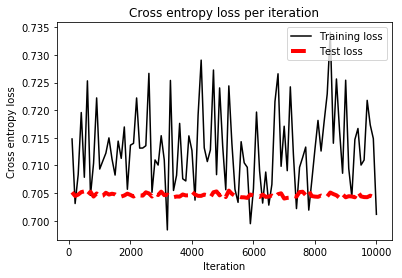

In [43]:
plt.plot(i_data, train_loss, 'k-', label='Training loss')
plt.plot(i_data, test_loss, 'r--', label='Test loss', linewidth=4)
plt.title('Cross entropy loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('Cross entropy loss')
plt.legend(loc='upper right')
plt.show()

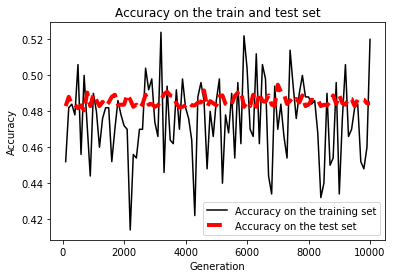

In [44]:
plt.plot(i_data, train_acc, 'k-', label='Accuracy on the training set')
plt.plot(i_data, test_acc, 'r--', label='Accuracy on the test set', linewidth=4)
plt.title('Accuracy on the train and test set')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()